In [1]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

In [4]:
def random_policy(N):
    '''
    Creates a random policy function.
    '''
    A = np.ones(N, dtype = float) / N
    def policy_function(state):
        return A
    return policy_function

In [5]:
def greedy_policy(Q):
    '''
    Creates a greedy policy based on Q values.
    '''
    
    def policy_function(state):
        # Implement this!
        props = Q[state]
        best_action = np.argmax(props)
        A = np.zeros((len(props)), dtype = float)
        A[best_action] = 1.0
        return A
    return policy_function

In [6]:
def generate_episode_from_limit_stochastic(bj_env, t_policy):
    episode = []
    state = bj_env.reset() #here, bj_env is the env instance
    while True:
        probs = t_policy(state)
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [9]:
def mc_control_off_policy(env, num_episodes, generate_episode, policy, gamma = 1.0):
    '''
    Monte Carlo Method Off-Policy
    '''
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = greedy_policy(Q)
        
    for i_episode in range(1, num_episodes + 1):
        # Let us monitor our progress :)
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Implement
        episode = generate_episode(env, policy)
        
        G = 0.0
        W = 1.0
        discounts = np.array([gamma**i for i in range(len(episode)+1)]) 

        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discounts[t] * G + reward

            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])

            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./policy(state)[action]
        
    return Q, policy

Episode 500000/500000.

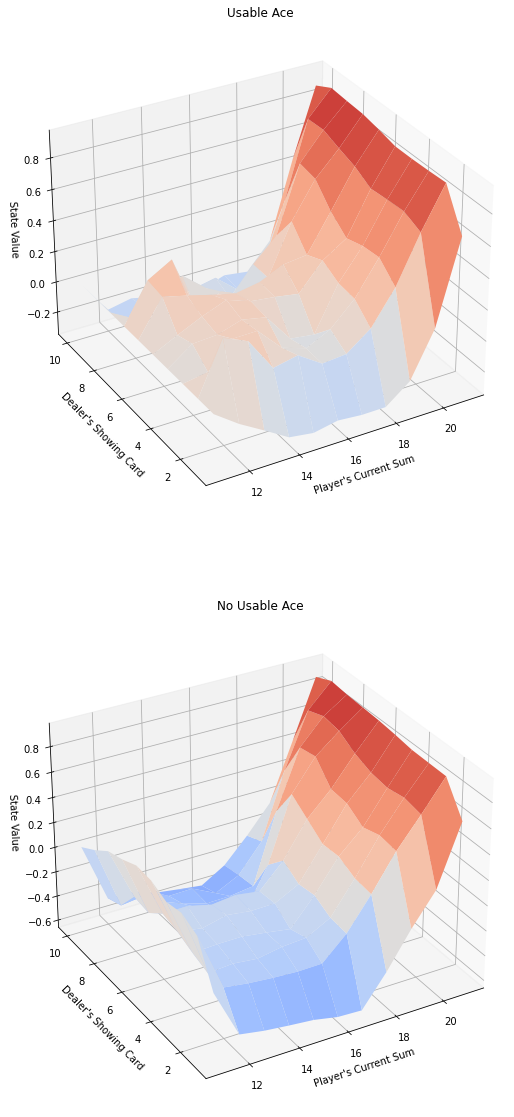

In [10]:
policy = random_policy(env.action_space.n)
Q, policy = mc_control_off_policy(env, num_episodes = 500000, generate_episode = generate_episode_from_limit_stochastic, policy = policy)

V = dict((k,np.max(v)) for k, v in Q.items())

plot_blackjack_values(V)

In [25]:
def choose_action(env, i_policy, state):
    probs = [i_policy(a, state) for a in env.action_space]
    return np.random.choice(self.action_space, p=probs)
def score(env, i_policy, n_samples=1000):
    rewards = []
    for _ in range(n_samples):
        state = env.reset()
        cum_rewards = 0
        while True:
            probs = i_policy(state)
            action = np.random.choice(np.arange(2), p=probs)
            observation, reward, done, _ = env.step(action)
            cum_rewards += reward
            if done:
                rewards.append(cum_rewards)
                break
    return np.mean(rewards)

In [27]:
print("Off-policy : {}".format(score(env, policy, n_samples=100)))
print("Off-policy : {}".format(score(env, policy, n_samples=1000)))
print("Off-policy : {}".format(score(env, policy, n_samples=10000)))
print("Off-policy : {}".format(score(env, policy, n_samples=100000)))

Off-policy : -0.43
Off-policy : -0.371
Off-policy : -0.3776
Off-policy : -0.39589


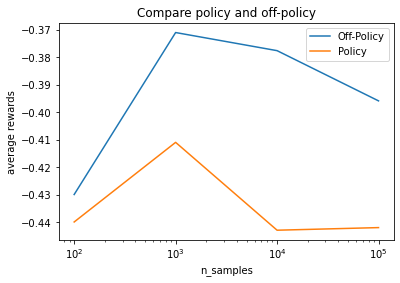

In [29]:
X = [100, 1000, 10000, 100000]
Y1 = [-0.43, -0.371, -0.3776, -0.39589]
Y2 = [-0.44, -0.411, -0.443, -0.44205]
import matplotlib.pyplot as plt
plt.semilogx(X, Y1, label = "Off-Policy")
plt.semilogx(X, Y2, label = "Policy")
plt.xlabel('n_samples')
plt.ylabel('average rewards')
plt.title('Compare policy and off-policy')

plt.legend()

plt.show()